# Analyzing the Effect of Nutrition (Specifically Protein Content) on COVID-19 Cases Around the World

By: Justin Lu

In [57]:
import os
for dirname, _, filenames in os.walk('/kaggle/input/covid19-healthy-diet-dataset/Protein_Supply_Quantity_Data.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [58]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures
import warnings
warnings.filterwarnings('ignore')

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import datetime
from scipy.stats import mode

In [60]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Source: Maria Ren on Kaggle
* Nutritional data from the UN's Food and Agriculture Organization
* Population data from the Population Reference Bureau
* COVID-19 data from Johns Hopkins Center for Systems Science and Engineering

In [61]:
protein = pd.read_csv('/kaggle/input/covid19-healthy-diet-dataset/Protein_Supply_Quantity_Data.csv')
protein.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetables,Miscellaneous,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0000,9.7523,0.0277,0.0,35.9771,0.4067,0.0647,0.5824,3.1337,...,1.1370,0.0462,4.5,29.8,0.088499,0.002595,0.054501,0.031404,38928000.0,%
1,Albania,0.1840,27.7469,0.0711,0.0,14.2331,1.8069,0.6274,1.2757,7.6582,...,3.2456,0.0544,22.3,6.2,0.121705,0.003277,0.068569,0.049859,2838000.0,%
2,Algeria,0.0323,13.8360,0.0054,0.0,26.5633,1.2916,0.6350,1.1624,3.5088,...,3.1267,0.1399,26.6,3.9,0.043274,0.002279,0.030983,0.010012,44357000.0,%
3,Angola,0.6285,15.2311,0.0277,0.0,20.3882,0.1756,5.4436,1.2754,7.6248,...,0.8133,0.0924,6.8,25,0.001556,0.000080,0.000363,0.001113,32522000.0,%
4,Antigua and Barbuda,0.1535,33.1901,0.1289,0.0,10.5108,0.4850,8.2146,1.2586,16.0670,...,1.6024,0.2947,19.1,NaN,0.075510,0.003061,0.058163,0.014286,98000.0,%


In [62]:
protein.shape

(170, 32)

In [63]:
protein.columns

Index(['Country', 'Alcoholic Beverages', 'Animal Products', 'Animal fats',
       'Aquatic Products, Other', 'Cereals - Excluding Beer', 'Eggs',
       'Fish, Seafood', 'Fruits - Excluding Wine', 'Meat',
       'Milk - Excluding Butter', 'Offals', 'Oilcrops', 'Pulses', 'Spices',
       'Starchy Roots', 'Stimulants', 'Sugar Crops', 'Sugar & Sweeteners',
       'Treenuts', 'Vegetal Products', 'Vegetable Oils', 'Vegetables',
       'Miscellaneous', 'Obesity', 'Undernourished', 'Confirmed', 'Deaths',
       'Recovered', 'Active', 'Population', 'Unit (all except Population)'],
      dtype='object')

## Cleaning
Based on a cursory overview of the columns in our dataset, we can tell that most of these variables *could* be significant predictors of COVID-19 spread. The last column, `Unit (all except Population)`, is potentially less useful, as it is just an indication that the data we are working with are all in percentages.

In [64]:
protein = protein.drop(['Unit (all except Population)'], axis = 1)
protein.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetable Oils,Vegetables,Miscellaneous,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population
0,Afghanistan,0.0000,9.7523,0.0277,0.0,35.9771,0.4067,0.0647,0.5824,3.1337,...,0.0000,1.1370,0.0462,4.5,29.8,0.088499,0.002595,0.054501,0.031404,38928000.0
1,Albania,0.1840,27.7469,0.0711,0.0,14.2331,1.8069,0.6274,1.2757,7.6582,...,0.0084,3.2456,0.0544,22.3,6.2,0.121705,0.003277,0.068569,0.049859,2838000.0
2,Algeria,0.0323,13.8360,0.0054,0.0,26.5633,1.2916,0.6350,1.1624,3.5088,...,0.0269,3.1267,0.1399,26.6,3.9,0.043274,0.002279,0.030983,0.010012,44357000.0
3,Angola,0.6285,15.2311,0.0277,0.0,20.3882,0.1756,5.4436,1.2754,7.6248,...,0.0092,0.8133,0.0924,6.8,25,0.001556,0.000080,0.000363,0.001113,32522000.0
4,Antigua and Barbuda,0.1535,33.1901,0.1289,0.0,10.5108,0.4850,8.2146,1.2586,16.0670,...,0.0430,1.6024,0.2947,19.1,NaN,0.075510,0.003061,0.058163,0.014286,98000.0


Another area of cleaning that must be done is the presence of NaN (empty or missing) values in the dataset. The process of dealing with these missing values is known as **data imputation**. Now, we take a look at what values in the dataset are missing and how to deal with it before we start analyzing/creating models.

In [65]:
protein.isna().sum()

Country                      0
Alcoholic Beverages          0
Animal Products              0
Animal fats                  0
Aquatic Products, Other      0
Cereals - Excluding Beer     0
Eggs                         0
Fish, Seafood                0
Fruits - Excluding Wine      0
Meat                         0
Milk - Excluding Butter      0
Offals                       0
Oilcrops                     0
Pulses                       0
Spices                       0
Starchy Roots                0
Stimulants                   0
Sugar Crops                  0
Sugar & Sweeteners           0
Treenuts                     0
Vegetal Products             0
Vegetable Oils               0
Vegetables                   0
Miscellaneous                0
Obesity                      3
Undernourished               7
Confirmed                    9
Deaths                       9
Recovered                    9
Active                      12
Population                   0
dtype: int64

There are many ways to go about imputing a missing value, but for this purpose, I chose to fill them with the average value of that specific column.
We can see that some data pertaining to health in the countries, specifically the `Obesity` and `Undernourished` columns, are missing. For these two missing columns, I decided to impute with the average of the column. For the `Confirmed`, `Deaths`, `Recovered`, and `Active` columns, it was possible that data was unavailable/not provided. For example, it is difficult to obtain COVID data from North Korea, because their government probably would not provide it. It is also possible that, at the time that this data was obtained, some countries had not shown cases yet because there was no travel to or from that country. (We know now that every country on the planet has experienced cases of COVID-19.) Therefore, to keep things consistent, I opted to remove these countries from the analysis.

In [66]:
protein['Undernourished'] = protein['Undernourished'].replace({'<2.5': 2.5})
protein['Undernourished'] = np.array(protein['Undernourished']).astype(np.float)

In [67]:
protein['Obesity'] = protein['Obesity'].fillna(protein['Obesity'].mean())
protein['Undernourished'] = protein['Undernourished'].fillna(np.nanmean(protein['Undernourished']))

In [68]:
protein = protein.drop(np.array(protein[protein['Confirmed'].isna() == True].index), axis = 0).reset_index(drop = True)

In [69]:
# cleaned dataset 
protein

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetable Oils,Vegetables,Miscellaneous,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population
0,Afghanistan,0.0000,9.7523,0.0277,0.0000,35.9771,0.4067,0.0647,0.5824,3.1337,...,0.0000,1.1370,0.0462,4.5,29.800000,0.088499,0.002595,0.054501,0.031404,38928000.0
1,Albania,0.1840,27.7469,0.0711,0.0000,14.2331,1.8069,0.6274,1.2757,7.6582,...,0.0084,3.2456,0.0544,22.3,6.200000,0.121705,0.003277,0.068569,0.049859,2838000.0
2,Algeria,0.0323,13.8360,0.0054,0.0000,26.5633,1.2916,0.6350,1.1624,3.5088,...,0.0269,3.1267,0.1399,26.6,3.900000,0.043274,0.002279,0.030983,0.010012,44357000.0
3,Angola,0.6285,15.2311,0.0277,0.0000,20.3882,0.1756,5.4436,1.2754,7.6248,...,0.0092,0.8133,0.0924,6.8,25.000000,0.001556,0.000080,0.000363,0.001113,32522000.0
4,Antigua and Barbuda,0.1535,33.1901,0.1289,0.0000,10.5108,0.4850,8.2146,1.2586,16.0670,...,0.0430,1.6024,0.2947,19.1,11.229448,0.075510,0.003061,0.058163,0.014286,98000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,Venezuela (Bolivarian Republic of),0.1955,22.5411,0.1244,0.0000,21.6526,0.8707,2.6477,1.0662,11.8347,...,0.0533,1.0129,0.0267,25.2,21.200000,0.033042,0.000311,0.009324,0.023407,28645000.0
157,Vietnam,0.1555,20.4466,0.1555,0.0056,18.5247,0.7665,5.7435,0.7165,11.0426,...,0.0000,3.7216,0.0389,2.1,9.300000,0.000387,0.000000,0.000364,0.000023,96209000.0
158,Yemen,0.0000,10.0122,0.0188,0.0000,35.1179,0.4320,0.9392,0.4884,5.9453,...,0.0000,0.5448,0.0564,14.1,38.900000,0.004912,0.001398,0.002209,0.001304,29826000.0
159,Zambia,0.4824,9.8925,0.0338,0.0000,28.5182,0.5839,3.0126,0.0931,4.3158,...,0.0000,0.8039,0.0592,6.5,46.700000,0.010308,0.000228,0.007681,0.002399,18384000.0


## Exploratory Data Analysis

I want to extract some quick statistics and plots to better understand what the data distribution looks like.

In [70]:
top = protein[protein['Population'] > 100000000].sort_values(by = 'Confirmed', ascending = False)[:20]
top

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetable Oils,Vegetables,Miscellaneous,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population
153,United States of America,0.2946,32.4775,0.0264,0.0044,10.4594,2.0048,2.3873,0.5935,18.0875,...,0.0835,1.3981,0.0000,37.3,2.5,1.001868,0.040986,0.305060,NaN,3.298780e+08
20,Brazil,0.2807,29.0557,0.1266,0.0000,12.1671,1.1831,1.3537,0.7759,18.7486,...,0.0220,0.8089,0.0000,22.3,2.5,0.880347,0.034040,0.597154,0.249154,2.118120e+08
121,Russian Federation,0.3436,27.3905,0.0834,0.0000,16.2085,2.3071,3.2496,0.4123,12.6006,...,0.0245,1.6150,0.0442,25.7,2.5,0.494801,0.007713,0.340897,0.146191,1.467330e+08
97,Mexico,0.2784,23.4422,0.0107,0.0161,19.3737,2.8587,2.3287,0.9047,11.1188,...,0.0214,1.2473,0.0054,28.4,3.6,0.234561,0.027393,0.183818,0.023350,1.277920e+08
112,Pakistan,0.0000,21.0264,0.0604,0.0000,20.8679,0.7472,0.4151,0.2868,4.4830,...,0.1132,0.9358,0.0226,7.8,20.3,0.113888,0.002383,0.073286,0.038219,2.209400e+08
11,Bangladesh,0.0000,9.9195,0.0083,0.0000,31.7243,0.7216,5.8306,0.3069,1.2773,...,0.0000,1.2026,0.0249,3.4,14.7,0.108236,0.001385,0.055129,0.051722,1.698090e+08
44,Egypt,0.0052,12.4994,0.0467,0.0000,30.3504,0.5243,3.4934,1.0849,5.1077,...,0.0052,2.4916,0.0260,31.1,4.5,0.081416,0.003827,0.024224,0.053364,1.008030e+08
67,India,0.0077,11.2582,0.0306,0.0000,25.2794,0.7271,1.5537,0.6659,1.0179,...,0.0000,2.3343,0.0000,3.8,14.5,0.062728,0.001655,0.039531,0.021542,1.400100e+09
116,Philippines,0.1914,20.5089,0.3191,0.0000,23.2770,1.0211,6.6369,1.2763,9.6682,...,0.0000,1.9863,0.0558,6.0,13.3,0.051340,0.001400,0.014643,0.035297,1.095810e+08
68,Indonesia,0.0073,16.1640,0.0219,0.0000,27.3237,1.2821,10.1617,0.7430,2.9210,...,0.0000,1.2966,0.0073,6.9,8.3,0.027857,0.001327,0.013115,0.013415,2.717390e+08


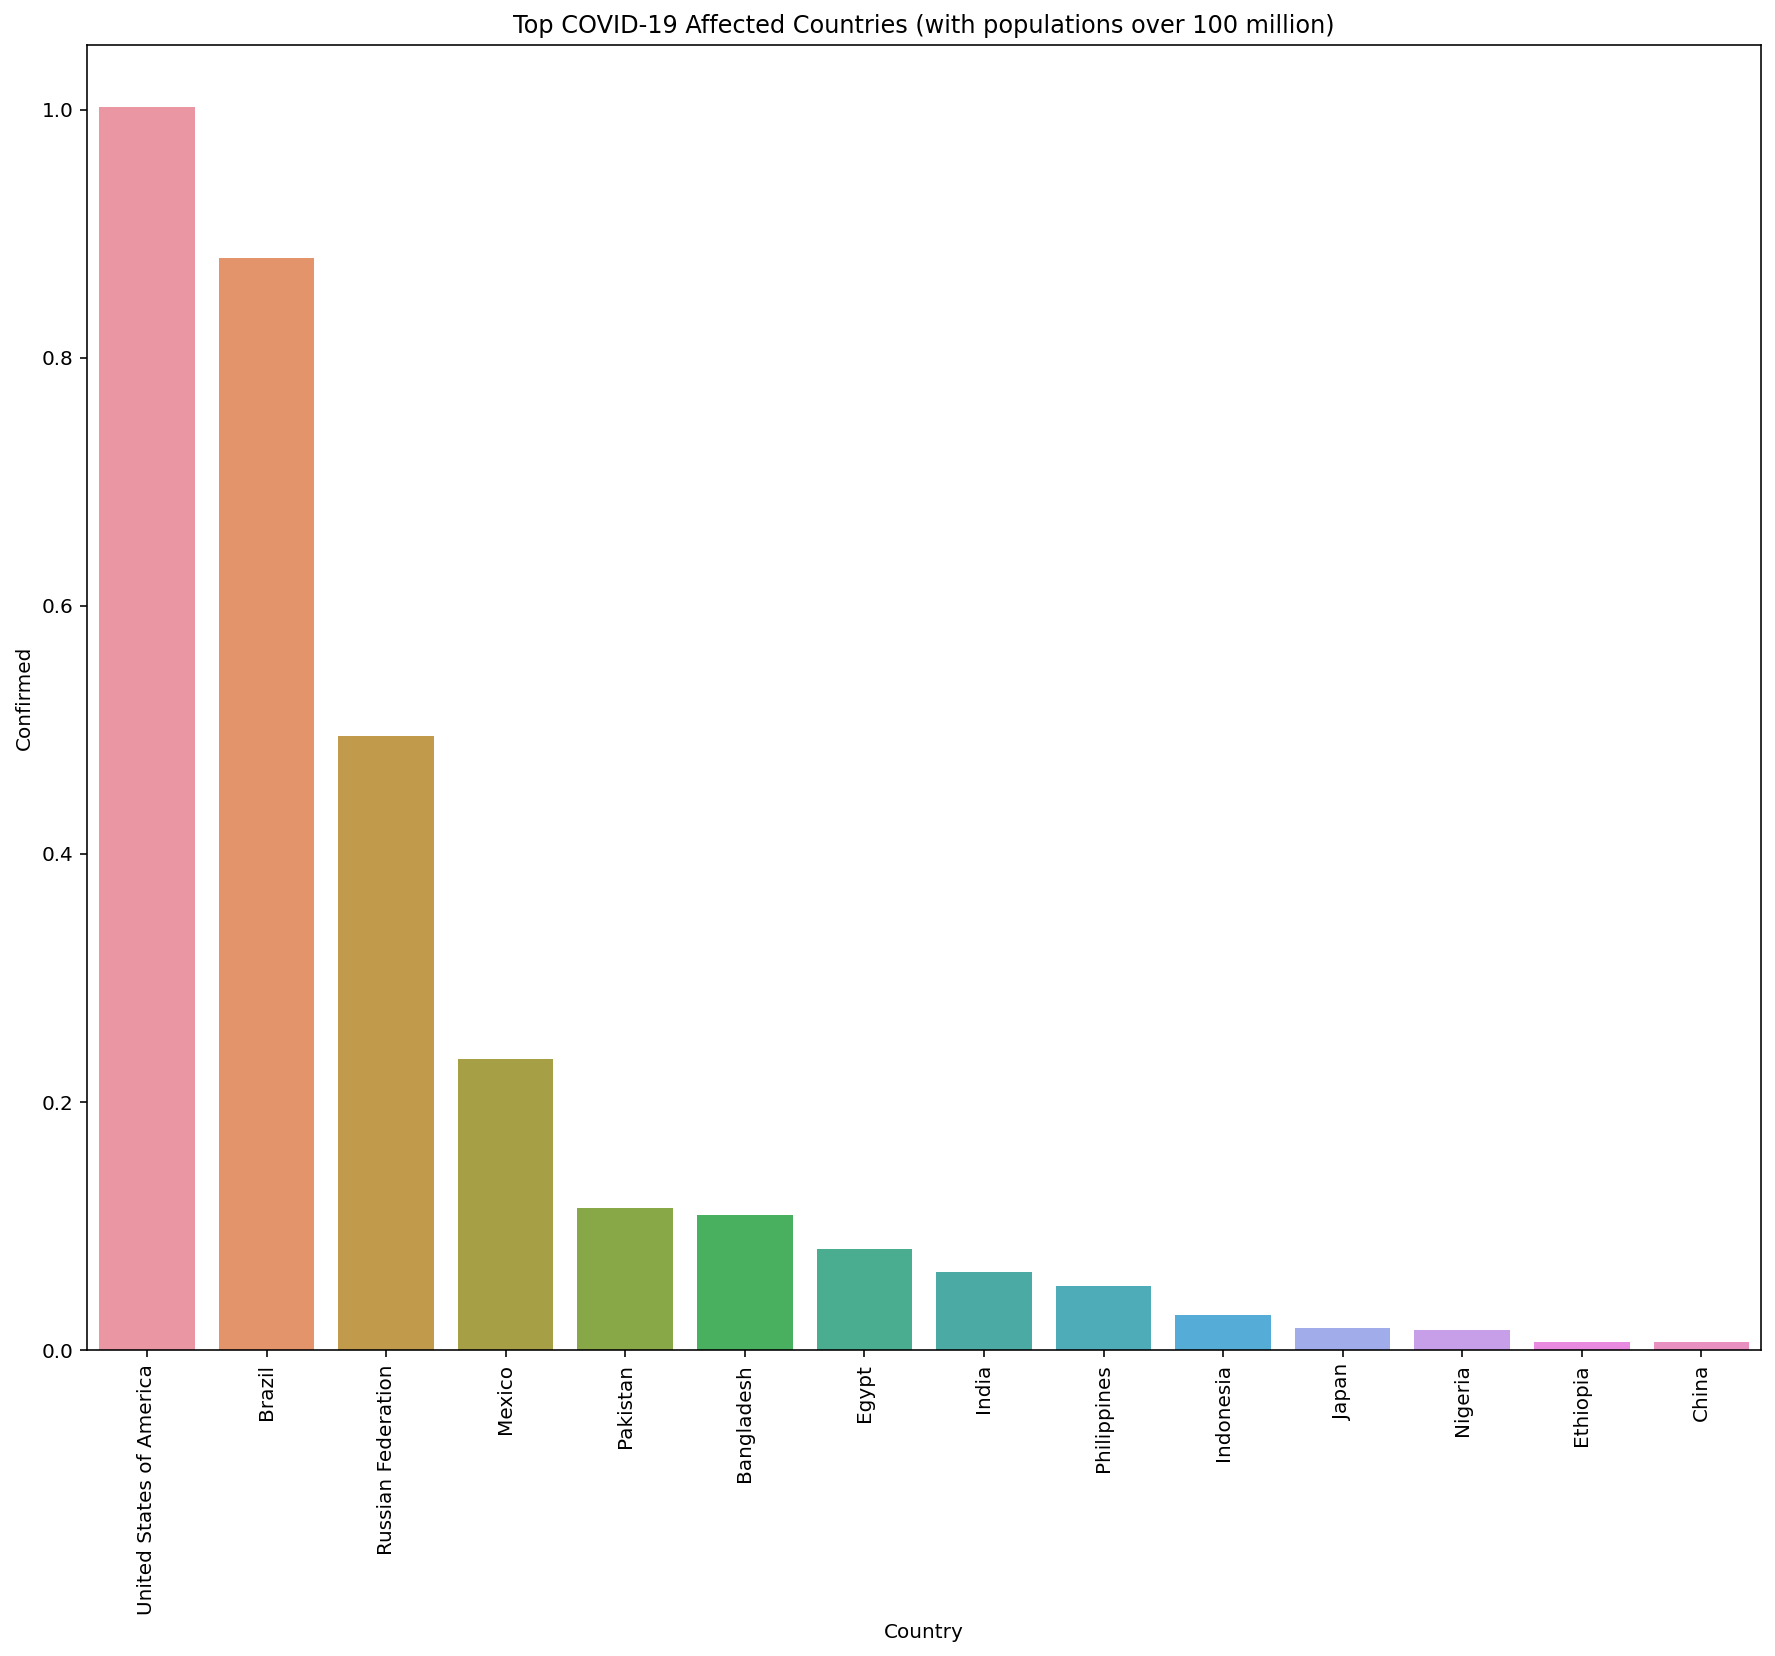

In [71]:
plt.figure(figsize=(15,12))
plt.title("Top COVID-19 Affected Countries (with populations over 100 million)")
ax = sns.barplot(x = top.Country, y = top.Confirmed)
suppress = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

I also wanted to view the distribution of confirmed case percentage across the countries in the dataset.

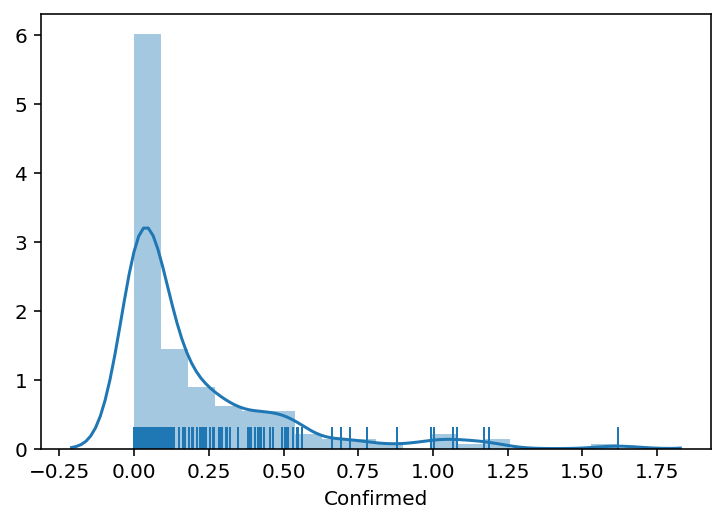

In [72]:
sns.distplot(protein['Confirmed'], rug = True)

To further cut down on the features I want to use in my models, I decided to extract features that I felt would be most useful in my analysis and model building. These features (available in the dataset) consisted of foods with high protein content, as well as the features pertaining to overall health of each country (i.e., obesity and undernourishment percentages).

I also decided to make this a classification problem to simplify the problem. I decided to predict whether a country's confirmed case rate is higher or lower than the average of the rate around the world.

For the baseline model, I chose these features: `Animal Products`, `Cereals - Excluding Beer`, `Eggs`, `Fish, Seafood`, `Meat`, `Treenuts`, `Vegetal Products`, `Vegetables`, `Obesity`, and `Undernourished` columns to predict the `Confirmed` variable.

In [73]:
test_dat = protein[['Animal Products', 'Cereals - Excluding Beer', 'Eggs', 
                  'Fish, Seafood', 'Meat', 'Treenuts', 'Vegetal Products', 
                  'Vegetables', 'Obesity', 'Undernourished', 'Confirmed']]
test_dat['Confirmed'] = (test_dat['Confirmed'] > test_dat['Confirmed'].mean()).astype(int)
test_dat

,Animal Products,Cereals - Excluding Beer,Eggs,"Fish, Seafood",Meat,Treenuts,Vegetal Products,Vegetables,Obesity,Undernourished,Confirmed
0,9.7523,35.9771,0.4067,0.0647,3.1337,0.1387,40.2477,1.1370,4.5,29.800000,0
1,27.7469,14.2331,1.8069,0.6274,7.6582,0.2677,22.2552,3.2456,22.3,6.200000,0
2,13.8360,26.5633,1.2916,0.6350,3.5088,0.2745,36.1694,3.1267,26.6,3.900000,0
3,15.2311,20.3882,0.1756,5.4436,7.6248,0.0092,34.7782,0.8133,6.8,25.000000,0
4,33.1901,10.5108,0.4850,8.2146,16.0670,0.0737,16.8161,1.6024,19.1,11.229448,0
...,...,...,...,...,...,...,...,...,...,...,...
156,22.5411,21.6526,0.8707,2.6477,11.8347,0.0000,27.4545,1.0129,25.2,21.200000,0
157,20.4466,18.5247,0.7665,5.7435,11.0426,0.3277,29.5617,3.7216,2.1,9.300000,0
158,10.0122,35.1179,0.4320,0.9392,5.9453,0.0188,39.9831,0.5448,14.1,38.900000,0
159,9.8925,28.5182,0.5839,3.0126,4.3158,0.0000,40.1117,0.8039,6.5,46.700000,0


## After Feature Selection/Engineering - Comparing Classification Methods
- Correlation matrix
- Standardization - converting predictor variables to standard units
- More weeding out of variables/engineering

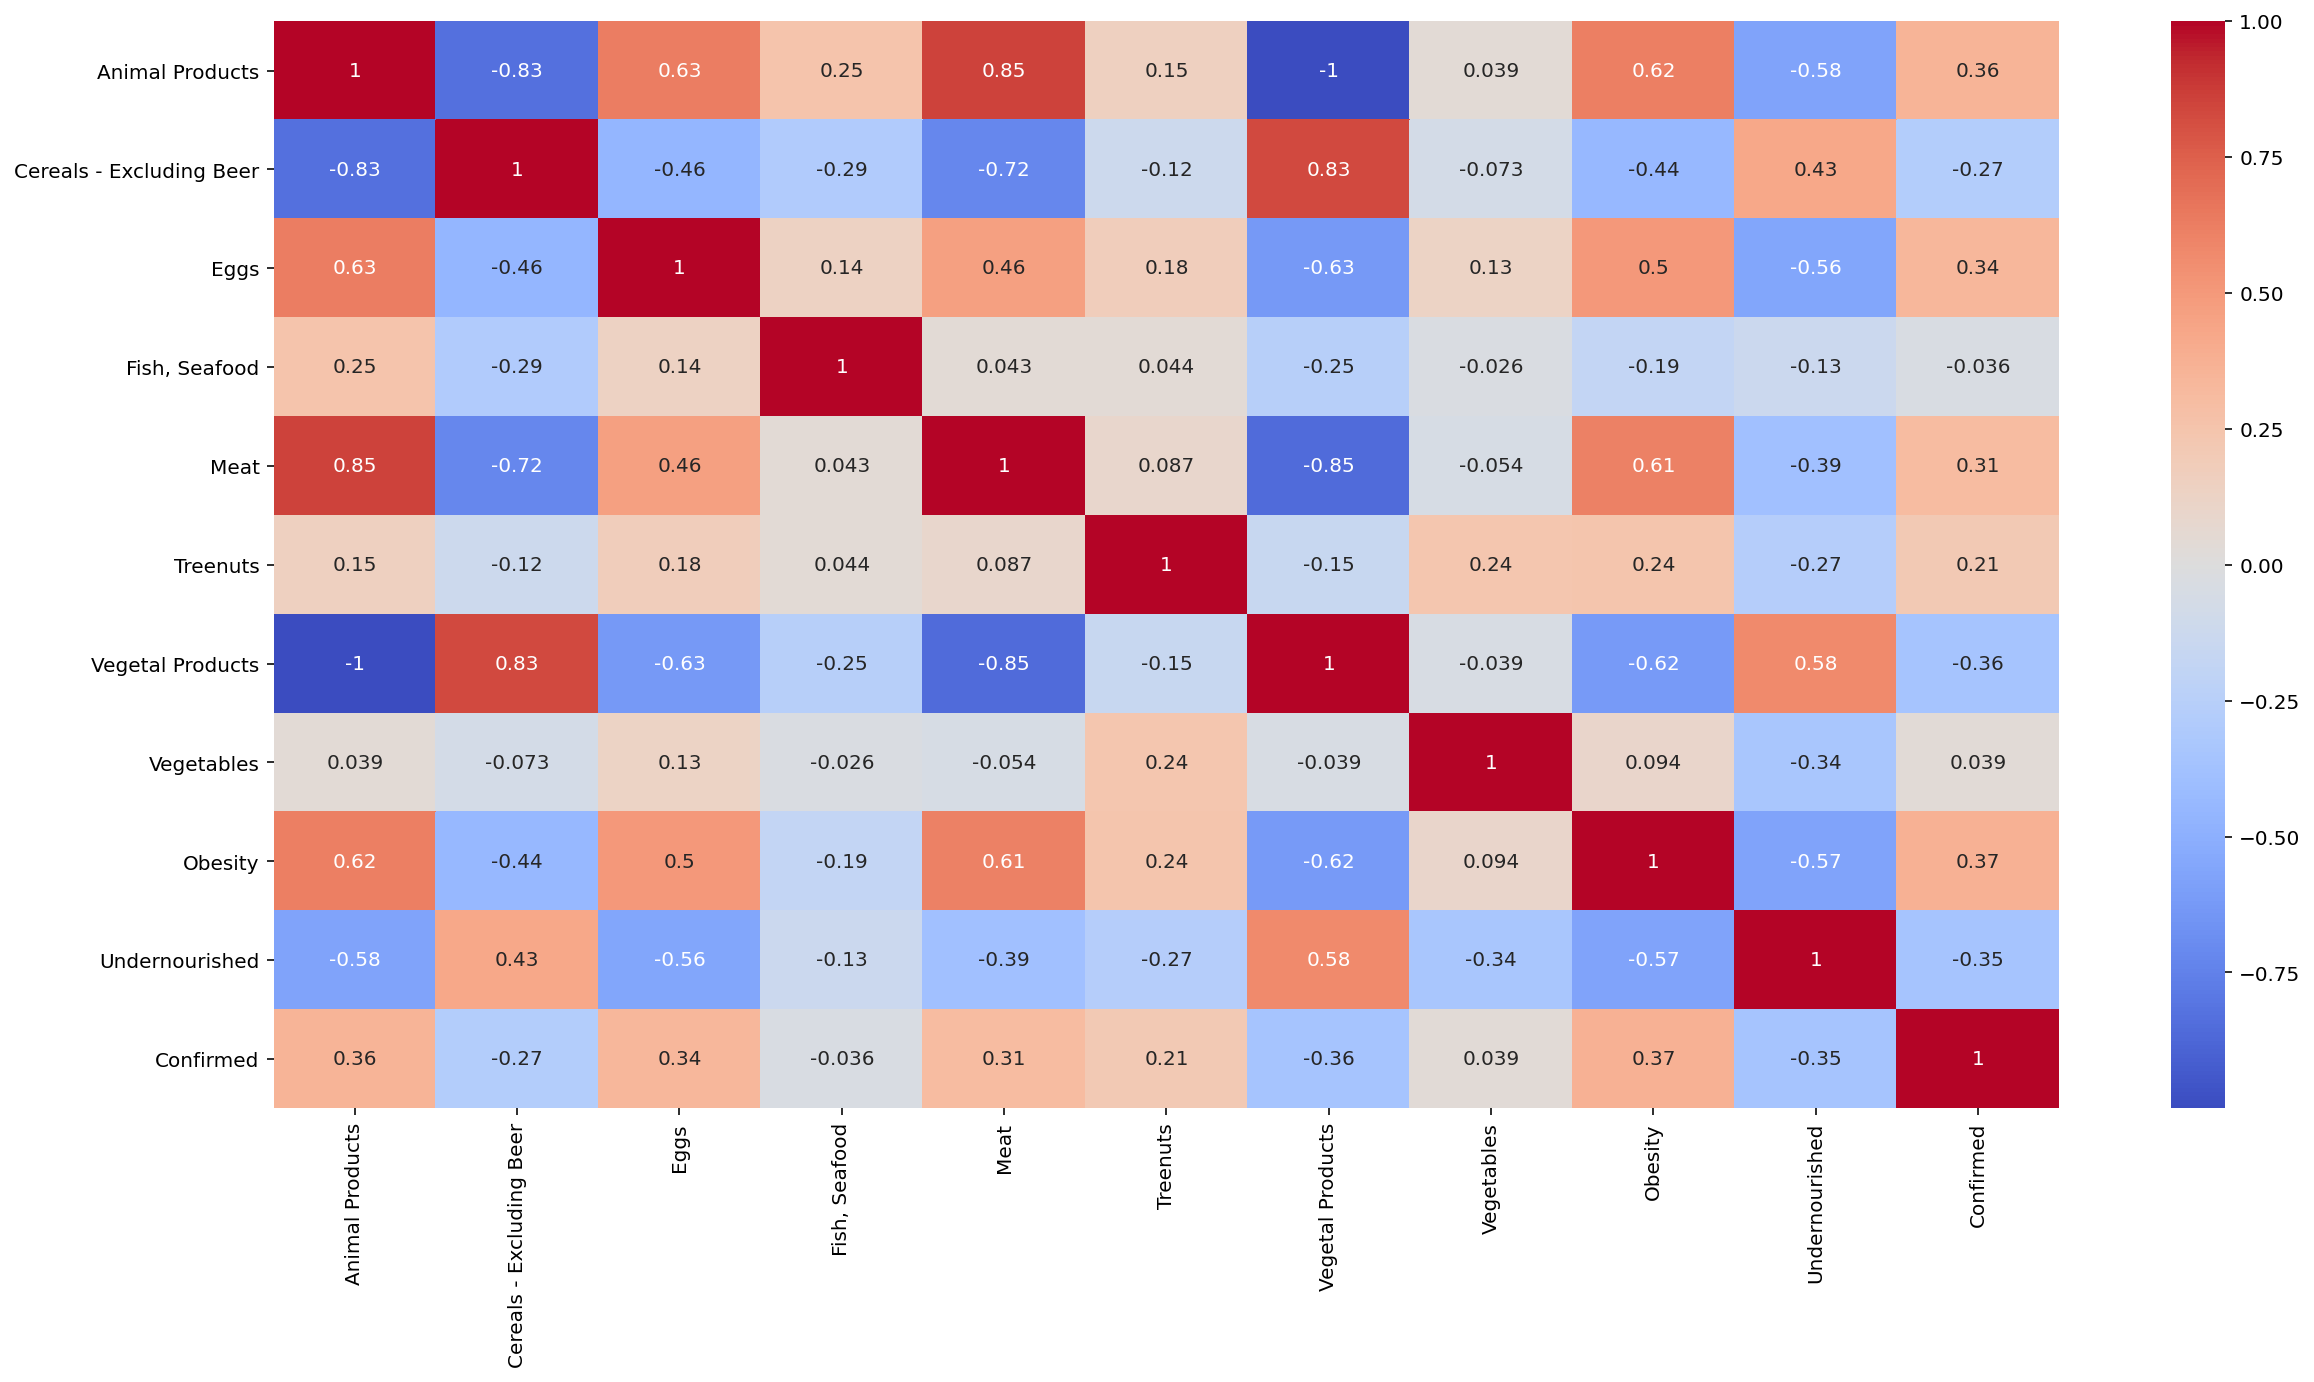

In [74]:
plt.figure(figsize=(20,10))
c = test_dat.corr()
corr = sns.heatmap(c, cmap="coolwarm", annot=True)

In [75]:
final_X = test_dat[['Animal Products', 'Obesity', 'Eggs', 'Vegetal Products', 'Undernourished']]
final_y = test_dat['Confirmed']
numcols = ['Animal Products', 'Obesity', 'Eggs', 'Vegetal Products', 'Undernourished']

In [99]:
perc_pipe = Pipeline([
    ('imp', SimpleImputer(strategy = 'mean')),
     ('percentage_transform', StandardScaler())
])

ct = ColumnTransformer([ 
    ('perc_cols', perc_pipe, numcols)
])

pl = Pipeline([('feats', ct), ('reg', LogisticRegression())])

scores = []
for i in range(50):
    X_tr, X_ts, y_tr, y_ts = train_test_split(final_X, final_y, test_size=0.25)
    pl.fit(X_tr, y_tr)
    scores.append(pl.score(X_ts, y_ts))

np.mean(scores)

0.6770731707317073

In [100]:
perc_pipe = Pipeline([
    ('imp', SimpleImputer(strategy = 'mean')),
    ('percentage_transform', StandardScaler())
])

ct = ColumnTransformer([ 
    ('perc_cols', perc_pipe, numcols)
])

pl = Pipeline([('feats', ct), ('reg', DecisionTreeClassifier())])

scores = []
for i in range(50):
    X_tr, X_ts, y_tr, y_ts = train_test_split(final_X, final_y, test_size=0.25)
    pl.fit(X_tr, y_tr)
    scores.append(pl.score(X_ts, y_ts))

np.mean(scores)

0.6507317073170732

In [101]:
perc_pipe = Pipeline([
    ('imp', SimpleImputer(strategy = 'mean')),
    ('percentage_transform', StandardScaler())
])

ct = ColumnTransformer([ 
    ('perc_cols', perc_pipe, numcols)
])

pl = Pipeline([('feats', ct), ('reg', RandomForestClassifier())])

scores = []
for i in range(50):
    X_tr, X_ts, y_tr, y_ts = train_test_split(final_X, final_y, test_size=0.25)
    pl.fit(X_tr, y_tr)
    scores.append(pl.score(X_ts, y_ts))

np.mean(scores)

0.6887804878048782

The accuracy of using regression from sklearn is very fickle, as we can see. But, from the performance 

## Neural Network with Keras

In [102]:
test_dat.head()

,Animal Products,Cereals - Excluding Beer,Eggs,"Fish, Seafood",Meat,Treenuts,Vegetal Products,Vegetables,Obesity,Undernourished,Confirmed
0,9.7523,35.9771,0.4067,0.0647,3.1337,0.1387,40.2477,1.1370,4.5,29.800000,0
1,27.7469,14.2331,1.8069,0.6274,7.6582,0.2677,22.2552,3.2456,22.3,6.200000,0
2,13.8360,26.5633,1.2916,0.6350,3.5088,0.2745,36.1694,3.1267,26.6,3.900000,0
3,15.2311,20.3882,0.1756,5.4436,7.6248,0.0092,34.7782,0.8133,6.8,25.000000,0
4,33.1901,10.5108,0.4850,8.2146,16.0670,0.0737,16.8161,1.6024,19.1,11.229448,0


In [104]:
final_X = test_dat[['Animal Products', 'Obesity', 'Eggs', 'Vegetal Products', 'Undernourished']]
final_y = test_dat['Confirmed']

In [111]:
model = Sequential()
model.add(Dense(12, input_dim=5, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(final_X, final_y, epochs=100, batch_size=10, validation_split=0.33)

Epoch 1/100
11/11 [==============================] - 0s 12ms/step - loss: 7.5073 - accuracy: 0.2991 - val_loss: 6.5066 - val_accuracy: 0.3333
Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 6.5040 - accuracy: 0.2991 - val_loss: 5.6183 - val_accuracy: 0.3333
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 5.5874 - accuracy: 0.2991 - val_loss: 4.8309 - val_accuracy: 0.3333
Epoch 4/100
11/11 [==============================] - 0s 4ms/step - loss: 4.8007 - accuracy: 0.2991 - val_loss: 4.1158 - val_accuracy: 0.3333
Epoch 5/100
11/11 [==============================] - 0s 4ms/step - loss: 4.1407 - accuracy: 0.3084 - val_loss: 3.5233 - val_accuracy: 0.3333
Epoch 6/100
11/11 [==============================] - 0s 4ms/step - loss: 3.5919 - accuracy: 0.3084 - val_loss: 3.0029 - val_accuracy: 0.3333
Epoch 7/100
11/11 [==============================] - 0s 4ms/step - loss: 3.1520 - accuracy: 0.3178 - val_loss: 2.5691 - val_accuracy: 0.3519
Epoch 8/100


Epoch 59/100
11/11 [==============================] - 0s 4ms/step - loss: 0.5341 - accuracy: 0.7103 - val_loss: 0.5362 - val_accuracy: 0.5556
Epoch 60/100
11/11 [==============================] - 0s 4ms/step - loss: 0.5329 - accuracy: 0.7009 - val_loss: 0.5365 - val_accuracy: 0.5741
Epoch 61/100
11/11 [==============================] - 0s 4ms/step - loss: 0.5332 - accuracy: 0.7103 - val_loss: 0.5371 - val_accuracy: 0.5741
Epoch 62/100
11/11 [==============================] - 0s 4ms/step - loss: 0.5329 - accuracy: 0.7103 - val_loss: 0.5352 - val_accuracy: 0.5741
Epoch 63/100
11/11 [==============================] - 0s 4ms/step - loss: 0.5333 - accuracy: 0.7009 - val_loss: 0.5374 - val_accuracy: 0.5741
Epoch 64/100
11/11 [==============================] - 0s 4ms/step - loss: 0.5307 - accuracy: 0.7103 - val_loss: 0.5355 - val_accuracy: 0.5741
Epoch 65/100
11/11 [==============================] - 0s 4ms/step - loss: 0.5306 - accuracy: 0.7103 - val_loss: 0.5338 - val_accuracy: 0.5741
Epoch 

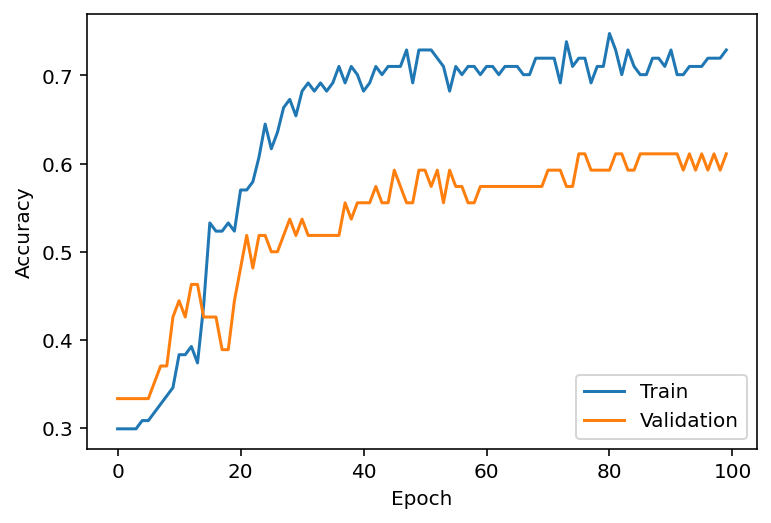

In [112]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

## Conclusion
This analysis must be taken with a grain of salt, as we simplified the problem by making it into a classification problem rather than a regression problem when we split the prediction variable into two groups. Therefore, although nutrition may be one of the factors in helping to predict COVID case rates, it should not be the sole predictor. 

However, we can definitely tell that nutrition, specifically the features used in our model, can contribute to predicting whether or not countries will have a higher-than-average COVID-19 case rate. Furthermore, the data is very limited, because there are only less than 200 countries in the dataset. What would be helpful for future analysis would be data that covers individual provinces/states/districts of countries, which will create more nuances that can be analyzed.